In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets

from keras.datasets import mnist
import timm

import numpy as np
import matplotlib.pyplot as plt

from src.FGSM import *

2025-08-08 20:28:58.042344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754699338.170652  884285 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754699338.208435  884285 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754699338.527269  884285 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754699338.527310  884285 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754699338.527313  884285 computation_placer.cc:177] computation placer alr

In [2]:
def print_torch_info():
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Number of GPUs:", torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("No CUDA-enabled GPU found.")

print_torch_info()

PyTorch version: 2.7.1+cu126
CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA RTX A6000


In [3]:
device = get_device()
print(f"Using device: {device}")
model = load_resnet_34(device)
train_loader, test_loader = get_dataloaders()
model = train_model(model, train_loader, epochs=5, lr=1e-3, device=device)



Using device: cuda


/nfshomes/shane10j/ImageAdversarial/environments/advEnv/lib64/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfshomes/shane10j/ImageAdversarial/environments/advEnv/lib64/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [09:04<00:00, 110.26it/s]


Epoch 1/5, Loss: 0.1489, Accuracy: 0.9603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [08:58<00:00, 111.43it/s]


Epoch 2/5, Loss: 0.0556, Accuracy: 0.9862


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [09:00<00:00, 111.05it/s]


Epoch 3/5, Loss: 0.0378, Accuracy: 0.9905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [08:58<00:00, 111.50it/s]


Epoch 4/5, Loss: 0.0253, Accuracy: 0.9930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [09:00<00:00, 110.98it/s]

Epoch 5/5, Loss: 0.0202, Accuracy: 0.9944


In [ ]:
#Saving fine-tuned model
#torch.save(model.state_dict(), 'src/fine-tuned_models/resnet34_finetuned.pth')

In [23]:
def pgd_iteration(prev_perturbation, alpha, epsilon, data_gradient):
    unclipped_perturbation = prev_perturbation + alpha * torch.sign(data_gradient)
    clipped_perturbation = torch.clamp(unclipped_perturbation, -epsilon, epsilon)
    return clipped_perturbation


def execute_pgd(model, device, test_loader, epsilon, alpha, iterations_T, num_images=5):
    #Load Data
    image_count = 0
    incorrectly_classified = 0
    images_tried = 0
    initial_images = []
    perturbed_images = []
    corresponding_labels = []
    for images, labels in test_loader:
        images_tried += 1
        images, labels = images.to(device), labels.to(device)
        _, init_pred = model(images).max(1)
        if init_pred == labels:
            print("Image initially classified correctly as: ", init_pred.item())
            image_count += 1
            initial_images.append(images.detach())
            criterion = nn.CrossEntropyLoss()
            initial_perturbation = torch.zeros_like(images) #Starting with just zeros
            #initial_perturbation = (torch.randint(0, 2, images.shape) * 2 - 1) * epsilon #Starting on random edge of epsilon ball
            perturbation = initial_perturbation
            perturbation = perturbation.to(images.device)
            perturbed_image = images + perturbation
            for i in range(iterations_T):
                perturbed_image.requires_grad = True
                outputs = model(perturbed_image)
                loss = criterion(outputs, labels)
                model.zero_grad()
                loss.backward()
                data_gradient = perturbed_image.grad.data.detach()
                perturbation = pgd_iteration(perturbation, alpha, epsilon, data_gradient)
                perturbed_image = torch.clamp(images + perturbation, 0.0, 1.0).detach()
            perturbed_images.append(perturbed_image.detach())
            adv_outputs = model(perturbed_image)
            _, adv_pred = adv_outputs.max(1)
            print("Adversarial image classified as: ", adv_pred.item())
            if adv_pred != init_pred:
                incorrectly_classified += 1
            corresponding_labels.append((labels, adv_pred))
        if image_count == num_images:
            break
    print("Number of images tried: ", images_tried)
    try:
        print("Percentage of perturbed images incorrectly classified: ", (incorrectly_classified/image_count)*100)
    except ZeroDivisionError:
        print("Model did not correctly classify any images")
    return initial_images, perturbed_images, corresponding_labels

In [24]:
device = get_device()
print(f"Using device: {device}")
train_loader, test_loader = get_dataloaders()
model = load_resnet_34(device)
#model = load_vit_base_patch16_224(device)
#model = train_model(model, train_loader, epochs=1, lr=1e-3, device=device)
model.load_state_dict(torch.load('src/fine-tuned_models/resnet34_finetuned.pth'))
epsilon = 0.007
orig, perturbed, labels = execute_pgd(model, device, test_loader, epsilon, 0.01, 10)



Using device: cuda
Image initially classified correctly as:  7
Adversarial image classified as:  4
Image initially classified correctly as:  2
Adversarial image classified as:  4
Image initially classified correctly as:  1
Adversarial image classified as:  4
Image initially classified correctly as:  0
Adversarial image classified as:  8
Image initially classified correctly as:  4
Adversarial image classified as:  4
Number of images tried:  5
Percentage of perturbed images incorrectly classified:  80.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


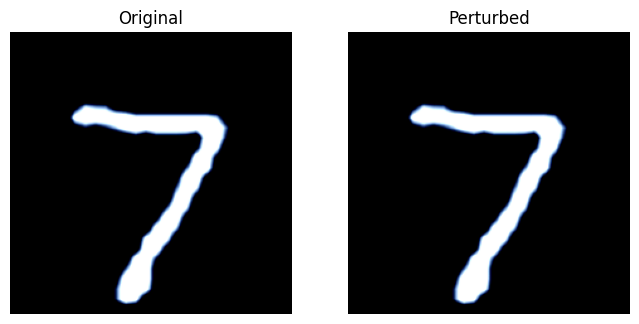

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  7
Adversarial label:  4


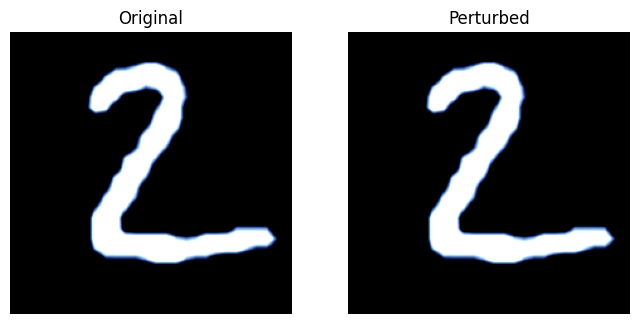

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Original label:  2
Adversarial label:  4


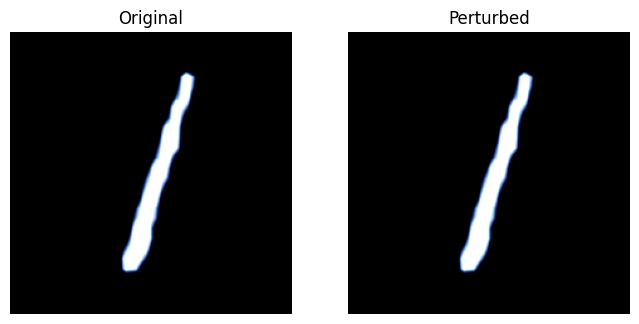

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  1
Adversarial label:  4


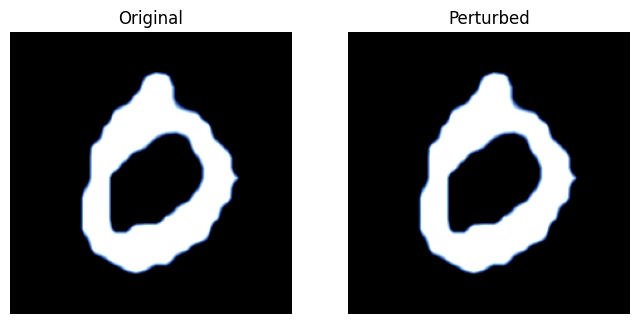

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original label:  0
Adversarial label:  8


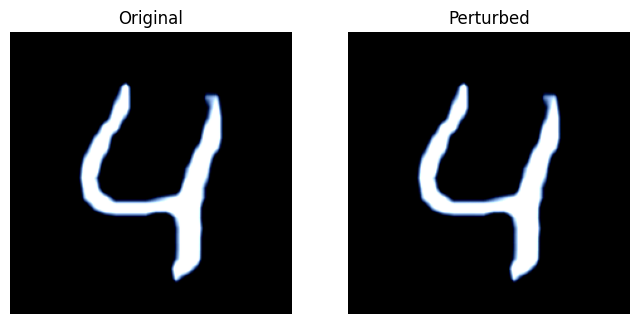

Original label:  4
Adversarial label:  4


In [25]:
if len(orig) != 0:
    for idx in range(len(orig)):
        visualize(orig[idx], perturbed[idx])
        print("Original label: ", labels[idx][0].item())
        print("Adversarial label: ", labels[idx][1].item())